# Setup:


## Installing the required packages:
The following piece of code will check wether the packages required for this Jupyter Notebook are installed. If they aren't yet installed it will automatically install them.

In [131]:
%pip install numpy control scipy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import packages:
The following piece of code will import the packages that will be used in the code. Take note of the chosen shortcuts. If you have no experience with the [NumPy](https://numpy.org/) library, read the documentation and do some tutorials. It is very important for matrix operations in Python.

In [132]:
from typing import Optional, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import scipy.signal as sig

## Plotting functions:
Define the plotting functions that will be used in the exercises. If you are interested, have a look.

In [133]:
# Function: plot_helpers
# Description: Adds labels and a legend to a plot.
# Input: None
# Output: None
# Variables:
#   - None
# Functionality: This function adds labels and a legend to a plot.
    
def plot_helpers() -> None:
    plt.xlabel('Time')
    plt.ylabel('Output')
    plt.legend()

    
# Function: plot_step_responses
# Description: Plots the step response of a system.
# Input:
#   - A Tuple of arrays containing the time and output of the continuous, forward euler, backward euler, tustin, and zero order hold systems.
# Output: None
# Variables:
#   - None
# Functionality: This function plots the step response of a system.
 
def plot_step_responses(t_stable_cont: np.array, y_stable_cont: np.array,
                        t_stable_eulerf: np.array, y_stable_eulerf: np.array,
                        t_stable_eulerb: np.array, y_stable_eulerb: np.array,
                        t_stable_tust: np.array, y_stable_tust: np.array,
                        t_stable_zoh: np.array, y_stable_zoh: np.array) -> None:
    
    plt.figure(figsize=[24, 16])
    plt.subplot(3, 2, 1)
    plt.plot(t_stable_cont, y_stable_cont, label='Continuous System')
    plt.plot(t_stable_eulerf, y_stable_eulerf, label='Forward Euler')
    plt.plot(t_stable_eulerb, y_stable_eulerb, label='Backward Euler')
    plt.plot(t_stable_tust, y_stable_tust, label='Tustin')
    plt.plot(t_stable_zoh, y_stable_zoh, label='Zero Order Hold')

    # Adding labels and title to the plot.
    
    plt.title('Step Response Combined')
    plot_helpers()
    

    plt.subplot(3, 2, 2)
    plt.plot(t_stable_cont, y_stable_cont, label='Continuous System', color = 'C0')

    # Adding labels and title to the plot.
    plt.title('Step Response Continuous')
    plot_helpers()


    plt.subplot(3, 2, 3)
    plt.plot(t_stable_eulerf, y_stable_eulerf, label='Forward Euler', color = 'C1')

    # Adding labels and title to the plot.
    plt.title('Step Response Forward Euler')
    plot_helpers()


    plt.subplot(3, 2, 4)
    plt.plot(t_stable_eulerb, y_stable_eulerb, label='Backward Euler', color = 'C2')

    # Adding labels and title to the plot.
    plt.title('Step Response Backward Euler')
    plot_helpers()


    plt.subplot(3, 2, 5)
    plt.plot(t_stable_tust, y_stable_tust, label='Tustin', color = 'C3')

    # Adding labels and title to the plot.
    plt.title('Step Response Tustin')
    plot_helpers()


    plt.subplot(3, 2, 6)
    plt.plot(t_stable_zoh, y_stable_zoh, label='Zero Order Hold', color = 'C4')

    # Adding labels and title to the plot.
    plt.title('Step Response Zero Order Hold')
    plot_helpers()

## Duckiebot System Matrices
This piece of Code defines the dynamics of the Duckiebot which shall be used as an example in question 1.

In [134]:
# Save the system matrices for later use.
A = [[0, 0.1], [0, 0]]
B = [[0], [1]]
C = [[1, 0]]
D = [[0]]

-------------------
# Exercise 1

## Exercise 1a:

Now we'll see how the different discretization schemes affect the step response of the duckiebot controller

In [135]:
def continuous_step_response(A: np.array, B: np.array, C:np.array, D:np.array) -> Tuple[np.array, np.array]:
    
    #TODO: Implement the continuous step response.

    # return the time and output vectors (as np.array) of the step response.
    return [t, y]

def discrete_step_response_euler_forward(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> Tuple[np.array, np.array]:
    
    #TODO: Implement the discrete step response using the forward Euler discretization.

    # return the time and output vectors (as np.array) of the step response.
    return [t, y]

def discrete_step_response_euler_backward(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> Tuple[np.array, np.array]:
    
    #TODO: Implement the discrete step response using the backward Euler discretization.

    # return the time and output vectors (as np.array) of the step response.
    return [t, y]

def discrete_step_response_tustin(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> Tuple[np.array, np.array]:
    
    #TODO: Implement the discrete step response using the Tustin discretization.

    # return the time and output vectors (as np.array) of the step response.
    return [t, y]

def discrete_step_response_zoh(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> Tuple[np.array, np.array]:
    
    #TODO: Implement the discrete step response using the Zero Order Hold discretization.

    # return the time and output vectors (as np.array) of the step response.
    return [t, y]

## Solution Exercise 1a:

In [136]:
# Basic structure of the functions is based on defining the continuous system and then using the ct.sample_system function to discretize the system.

def system_discretization_euler_forward_sol(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> np.array:
    
    sysc = ct.ss2tf(A, B, C, D)
    sysd_forward_euler = ct.sample_system(sysc, Ts = dt, method='euler')
    
    return sysd_forward_euler

def system_discretization_euler_backward_sol(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> np.array:
    
    sysc = ct.ss2tf(A, B, C, D)
    sysd_backward_euler = ct.sample_system(sysc, Ts = dt, method='backward_diff')
    
    return sysd_backward_euler

def system_discretization_tustin_sol(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> np.array:
    
    sysc = ct.ss2tf(A, B, C, D)
    sysd_tustin = ct.sample_system(sysc, Ts = dt, method='tustin')
    
    # Alternatively, you can use the following command:
    # sysd_tustin = sysc.sample_system(Ts = dt, method='tustin')
    
    return sysd_tustin

def system_discretization_zoh_sol(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> np.array:
    
    sysc = ct.ss2tf(A, B, C, D)
    sysd_zoh = ct.sample_system(sysc, Ts = dt, method='zoh')
    
    # Alternatively, you can use the following command:
    # sysd_zoh = sysc.sample_system(Ts = dt, method='zoh')
    
    return sysd_zoh



# The following functions are used to create the continuous and discrete step responses of the system.

# Create the continuous system step response.
def cont_solution (A: np.array, B: np.array, C:np.array, D:np.array) -> Tuple[np.array, np.array]:
    
    sysc = ct.ss(A, B, C, D)
    t_cont, y_cont = ct.step_response(sysc, input=0, output=0)
    
    return [t_cont, y_cont]


# Create the discrete system step response by first discretizing the system and then using the ct.step_response function.
# Use the previously defined functions to get the discretized systems and then use the ct.step_response function to get the step response.
def disc_solution (A: np.array, B: np.array, C:np.array, D:np.array, Ts:float) -> Tuple[np.array, np.array, np.array, np.array, np.array, np.array, np.array, np.array]:
    
        
    sysd_eulerf = system_discretization_euler_forward_sol(A, B, C, D, Ts)
    t_eulerf, y_eulerf = ct.step_response(sysd_eulerf, input=0, output=0)


    sysd_eulerb = system_discretization_euler_backward_sol(A, B, C, D, Ts)
    t_eulerb, y_eulerb = ct.step_response(sysd_eulerb, input=0, output=0)

    
    sysd_tust = system_discretization_tustin_sol(A, B, C, D, Ts)
    t_tust, y_tust = ct.step_response(sysd_tust, input=0, output=0)


    sysd_zoh = system_discretization_zoh_sol(A, B, C, D, Ts)
    t_zoh, y_zoh = ct.step_response(sysd_zoh, input=0, output=0)
    
    return [t_eulerf, y_eulerf, t_eulerb, y_eulerb, t_tust, y_tust, t_zoh, y_zoh]

## Exercise 1a: Test your code:
Set the Use_User_Implementation variable to True if you want to test your own implementation. However, it is currently set to False to prevent an error from occuring

In [137]:
def test_user_implementations(): 
    # Define the sampling time. Feel free to play around with this value.
    Ts = 2 

    # Test the user's implementation. 
    t_cont, y_cont = continuous_step_response(A, B, C, D)
    t_eulerf, y_eulerf = discrete_step_response_euler_forward(A, B, C, D, Ts)
    t_eulerb, y_eulerb = discrete_step_response_euler_backward(A, B, C, D, Ts)
    t_tust, y_tust = discrete_step_response_tustin(A, B, C, D, Ts)
    t_zoh, y_zoh = discrete_step_response_zoh(A, B, C, D, Ts)


    # Plotting the impulse response for each discretization scheme.
    plt.plot(t_cont, y_cont, label='Continuous System')
    plt.plot(t_eulerf, y_eulerf, label='Forward Euler')
    plt.plot(t_eulerb, y_eulerb, label='Backward Euler')
    plt.plot(t_tust, y_tust, label='Tustin')
    plt.plot(t_zoh, y_zoh, label='Zero Order Hold')

    # Adding labels and title to the plot.
    plt.xlabel('Time')
    plt.ylabel('Output')
    plt.title('Step Response')
    plt.legend()

    # Displaying the plot.
    plt.show()
    

Use_User_Implementations = False
if Use_User_Implementations:
    test_user_implementations()

## Solution Plots Exercise 1a:

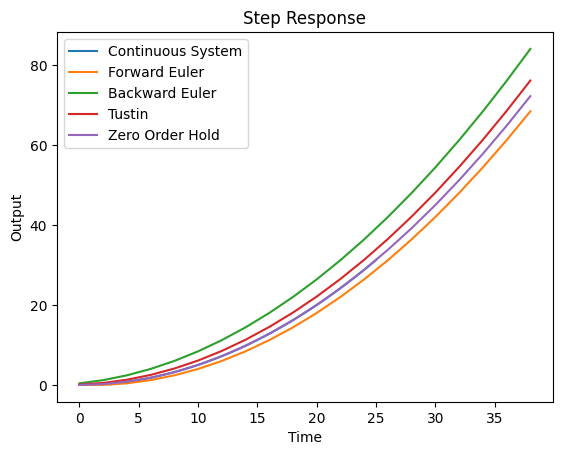

In [138]:
# Define the sampling time. Feel free to play around with this value.
Ts=2

# Call for the solutions and store them.
[t_cont_sol, y_cont_sol] = cont_solution(A, B, C, D)
[t_eulerf_sol, y_eulerf_sol, t_eulerb_sol, y_eulerb_sol, t_tust_sol, y_tust_sol, t_zoh_sol, y_zoh_sol] = disc_solution(A, B, C, D, Ts)

# Plotting the impulse response for each discretization scheme
plt.plot(t_cont_sol, y_cont_sol, label='Continuous System')
plt.plot(t_eulerf_sol, y_eulerf_sol, label='Forward Euler')
plt.plot(t_eulerb_sol, y_eulerb_sol, label='Backward Euler')
plt.plot(t_tust_sol, y_tust_sol, label='Tustin')
plt.plot(t_zoh_sol, y_zoh_sol, label='Zero Order Hold')

# Adding labels and title to the plot.
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Step Response')
plt.legend()



# Display the plot.
plt.show()

# The output of this cell is collapsed, you can view it by double clicking on the "Outputs are collapsed" text below.

##
Interpret the result (Hint: To see the differences between the different discretizations more clearly, increase `Ts` (more on this in Exercise 2)):

- Which Discretization is closest to the continuous system?
- Why can you only see 4 lines?
- Why do all the plots diverge?


-----
Since all of the above step responses diverge, we are unable to demonstrate that the different discretizations can make a stable system unstable. To remedy this we place poles at desired locations via the [Ackermann Formula](https://en.wikipedia.org/wiki/Ackermann%27s_formula#Ackermann's_formula).

In [139]:
def feedforward_kr(A: np.array, B: np.array, C: np.array, K: np.array) -> np.array:
    ABK = A - B @ K
    ABK_inv = np.linalg.inv(ABK)
    den = C @ ABK_inv @ B
    kr = - 1/den

    return kr


def acker(A: np.array, B: np.array, poles: List[float]) -> np.array:
    AB = A @ B
    R = np.concatenate((B, AB), axis=1)
    R_inv = np.linalg.inv(R)
    gamma = np.array([[0, 1]]) @ R_inv

    p_1 = poles[0]*(-1)
    p_2 = poles[1]*(-1)
    ab = p_1 + p_2
    b = p_1*p_2
    p_cl = A @ A + ab*A + b*np.identity(2)

    K = gamma @ p_cl

    return K


def place_poles_Ackermann(A: np.array, B: np.array, C: np.array,
                          D: float, poles: List) -> np.array:
    
    K=ct.acker(A, B, poles)
    
    # Create a new system representing the closed loop response
    clsys = ct.StateSpace(A - B @ K, B, C, D)

    # Compute the feedforward gain
    kr = feedforward_kr(A, B, C, K)
    
    # Scale the input by the feedforward gain
    clsys *= kr

    # Return gains and closed loop system dynamics
    return clsys

## Exercise 1b:

In this exercise you will:
- Try to make all the discretizations stable via changing the desired poles `p_des`.
- Try to make all the discretizations stable via changing the `Ts`.

Notes: 
- The function as is will not run. To make it run, change the Use_User_Implementation variable to True.
- To start off with, not all the step responses are stable.
- We will reuse the functions defined in 3a. If you couldn't solve them, use `cont_solution` and `disc_solution` where indicated.

In [140]:
def test_user_implementations():
    # Choose your desired poles. Feel free to play around with them.
    p_des = [-0.5+3j, -0.5-3j] 

    # Define the sampling time. Feel free to play around with this value.
    Ts=0.25

    # Compute the closed loop system dynamics using Ackermann's formula.
    clsys_p = place_poles_Ackermann(A=A, B=B, C=C, D=0,
                                        poles=p_des)
    t_p, y_p = ct.step_response(clsys_p, input=0, output=0)

    # Define the system matrices and sampling time
    A_stable = clsys_p.A
    B_stable = clsys_p.B
    C_stable = clsys_p.C
    D_stable = clsys_p.D



    # Compute the step response of the continuous closed loop system. 
    # If you couldn't solve the previous exercise, you can use the solution. For that replace the function call with the following:
    # [t_stable_cont, y_stable_cont] = cont_solution(A_stable, B_stable, C_stable, D_stable)
    t_stable_cont, y_stable_cont = continuous_step_response(A_stable, B_stable, C_stable, D_stable)



    # Compute the step response of the discrete closed loop system using the different discretization schemes. 
    # If you couldn't solve the previous exercise, you can use the solution. For that replace the function call with the following:
    # [t_stable_eulerf, y_stable_eulerf, t_stable_eulerb, y_stable_eulerb, t_stable_tust, y_stable_tust, t_stable_zoh, y_stable_zoh] = disc_solution(A_stable, B_stable, C_stable, D_stable, Ts)
    t_stable_eulerf, y_stable_eulerf = discrete_step_response_euler_forward(A_stable, B_stable, C_stable, D_stable, Ts)
    t_stable_eulerb, y_stable_eulerb = discrete_step_response_euler_backward(A_stable, B_stable, C_stable, D_stable, Ts)
    t_stable_tust, y_stable_tust = discrete_step_response_tustin(A_stable, B_stable, C_stable, D_stable, Ts)
    t_stable_zoh, y_stable_zoh = discrete_step_response_zoh(A_stable, B_stable, C_stable, D_stable, Ts)



    # Package the results for plotting.
    values_to_plot = [t_stable_cont, y_stable_cont,
                    t_stable_eulerf, y_stable_eulerf,
                    t_stable_eulerb, y_stable_eulerb,
                    t_stable_tust, y_stable_tust,
                    t_stable_zoh, y_stable_zoh]

    # Plot the step responses.
    plot_step_responses(*values_to_plot)
    
    
    
Use_User_Implementations = False
if Use_User_Implementations:
    test_user_implementations()
else:
    print("The user's implementations are not being used. Set the Use_User_Implementations variable to True to use the user's implementations.")

The user's implementations are not being used. Set the Use_User_Implementations variable to True to use the user's implementations.


Interpret your findings with respect to the following questions:

- Which of these graphs follows the contiunous system the closest?
- Does that change when you decrease or increase Ts?
- Why does that happen?
- For the default poles, what is the limit for Ts such that no discretization diverges?
- What happens when the poles are outside the unit circle? What happens when they are on it?

# End of Roy's part

-------------
# Emulation Exercises

Imagine you want to build a real duckiebot. Instead of plotting the changes a certain controller made to your system, you want to check the results by racing your duckiebot in your room.

This exercise will prepare you for exactly that scenario. Also in Control Systems the real world differs from the theoretical one. In real life, as seen in your lecture, you have to work in descrete time due to a fundamental problem: *"Computers can't do limit operations, hence they can't calculate derivatives exactly. Aprroximations are required. Instead of differential equations, finite difference equations are solved."*

## System Library

In here you will find different systems that show the advatages and disadvantages for the three discretization methods.

In [141]:
# Euler forward example
def create_system1():
    A = np.array([[-1, -1],
                  [2, -0.25]])
    B = np.array([[1],
                  [1]])
    C = np.array([[1, 1]])
    D = np.array([[0]])
    return ct.StateSpace(A, B, C, D)

# Euler backwards example
def create_system2():
    A = np.array([[-2, -3],
                  [1, -2]])
    B = np.array([[1],
                  [1]])
    C = np.array([[1, 1]])
    D = np.array([[0]])
    return ct.StateSpace(A, B, C, D)

#Create your own system here
def create_system3():
    A = np.array([[0, 0],
                  [0, 0]])
    B = np.array([[0],
                  [0]])
    C = np.array([[0, 0]])
    D = np.array([[0]])
    return ct.StateSpace(A, B, C, D)

#usage
system1 = create_system1()
system2 = create_system2()
system3 = create_system3()

-------
## Implementation of Descretization Methods

### Euler Forward Method

In [142]:
def euler_forward(system, dt):
    """
    Discretize a continuous-time system using the Euler forward method.

    Parameters:
    system: State-space system (instance of ct.StateSpace).
    dt: Time step for discretization.

    Returns:
    StateSpace(Ad, Bd, Cd, Dd): Discretized state-space matrices.
    """
    A, B, C, D = system.A, system.B, system.C, system.D
    I = np.eye(A.shape[0])
    Ad = I + dt * A
    Bd = dt * B
    Cd = C
    Dd = D
    return ct.StateSpace(Ad, Bd, Cd, Dd)

### Euler Backwards Method

In [143]:
def euler_backward(system, dt):
    """
    Discretize a continuous-time system using the Euler backward method.

    Parameters:
    system: State-space system (instance of ct.StateSpace).
    dt: Time step for discretization.

    Returns:
    StateSpace(Ad, Bd, Cd, Dd): Discretized state-space matrices.
    """
    A, B, C, D = system.A, system.B, system.C, system.D
    I = np.eye(A.shape[0])
    Ad = np.linalg.inv(I - dt * A)
    Bd = np.dot(Ad, dt * B)
    Cd = C
    Dd = D
    return ct.StateSpace(Ad, Bd, Cd, Dd)

### Tustin's Method

In [144]:
def tustin_method(system, dt):
    """
    Discretize a continuous-time system using Tustin's method (bilinear transformation).
    
    Parameters:
    system: State-space system (instance of ct.StateSpace).
    dt: Time step for discretization.
    
    Returns:
    StateSpace(Ad, Bd, Cd, Dd): Discretized state-space matrices.
    """
    A, B, C, D = system.A, system.B, system.C, system.D
    I = np.eye(A.shape[0])
    pre_matrix = np.linalg.inv(I - (dt / 2) * A)
    Ad = np.dot(pre_matrix, I + (dt / 2) * A)
    Bd = np.dot(pre_matrix, dt * B)
    Cd = C
    Dd = D
    return ct.StateSpace(Ad, Bd, Cd, Dd)

---------
## Console

This is where you change your system (eg. system1, system2, etc.) and vary the step time. Leave it as it is for exercises 1 and 2.

In [145]:
#change for exercise 3
dt =  0.4 # Time step
test = system1

-------
## Exercise 1: Stability Analysis with Eigenvalue Plots

Objective: Analyze and compare the stability of the Duckiebot steering system using different discretization methods.

Tasks:

	1.Create a fuction that discretizes the system using Euler forward, Euler backward, and Tustin’s methods for a given time step (dt = 1 seconds).

	2.Calculate the eigenvalues in the plot_eigenvalues() function.
	
	3.Use the provided plot_table function as well as the prior ones from task 1 and 2 to plot the eigenvalues in the complex plain and check them for stability. Hint: Stable systems will have eigenvalues with magnitudes less than 1.

### Solution Exercise 1

#### Task 1

In [146]:
def discretize(system, dt):
    '''
    Discretizes a continuous-time system into discrete-time systems using three methods: 
    Euler Forward, Euler Backward, and Tustin's method.

    Parameters:
    system: A continuous-time system represented as a ct.StateSpace object.
    dt: Time step for discretization.

    Returns:
    tuple: A tuple of discretized systems (dt_forward, dt_backward, dt_tustin), each representing 
    the input system discretized using Euler Forward, Euler Backward, and Tustin's method, respectively.
    '''
    # Discretize using each method
    dt_forward = euler_forward(system, dt)
    dt_backward = euler_backward(system, dt)
    dt_tustin = tustin_method(system, dt)
    
    return dt_forward, dt_backward, dt_tustin

#### Task 2

In [147]:
def plot_eigenvalues(system, method_name):
    '''
    Plots the eigenvalues of the discretized system's A matrix on the complex plane.

    Parameters:
    system: A discrete-time system, represented as a control.statesp.StateSpace object, 
            whose eigenvalues are to be plotted.
    method_name: A string representing the name of the discretization method used for 
                 this system. This name is used as a label in the plot.

    The function calculates the eigenvalues of the system's A matrix, prints them,
    and plots them on the complex plane. Each set of eigenvalues is labeled according 
    to the discretization method used.
    '''
    Ad = system.A
    eigenvalues = np.linalg.eigvals(Ad)
    print("Eigenvalues using " + method_name)
    print(eigenvalues)
    print("Magnetude")
    print(np.linalg.norm(eigenvalues[0]))
    print("\n")

    plt.scatter(eigenvalues.real, eigenvalues.imag, label=method_name)

#### Plotting function

In [148]:
def plot_table(dt_forward, dt_backward, dt_tustin):
    '''
    Plots the eigenvalues of three discretized systems on the complex plane to compare their stability.

    Parameters:
    dt_forward: Discretized system using the Euler Forward method (StateSpace object).
    dt_backward: Discretized system using the Euler Backward method (StateSpace object).
    dt_tustin: Discretized system using Tustin's method (StateSpace object).

    This function visualizes the eigenvalues of the given discretized systems on the complex plane.
    It helps in comparing the stability characteristics of the systems discretized using different methods.
    The function plots each set of eigenvalues with a different label corresponding to the discretization method.
    It also includes a unit circle for reference, aiding in the assessment of stability (eigenvalues inside the 
    unit circle indicate stability in discrete-time systems).
    '''
    plt.figure(figsize=(8, 6))
    
    plot_eigenvalues(dt_forward, 'Euler Forward')
    plot_eigenvalues(dt_backward, 'Euler Backward')
    plot_eigenvalues(dt_tustin, 'Tustin')
    
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('Eigenvalues of Discretized Systems')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))
    plt.grid(True)

    # adding unit circle for visualisation
    theta = np.linspace(0, 2 * np.pi, 100)  # 100 points between 0 and 2*pi
    x = np.cos(theta)  # x coordinates on the circle
    y = np.sin(theta)  # y coordinates on the circle
    plt.plot(x, y, linestyle = '--', color = 'grey')

    plt.show()

#### Task 3

Eigenvalues of continous system:
[-0.625+1.36358901j -0.625-1.36358901j]


Eigenvalues using Euler Forward
[0.75+0.54543561j 0.75-0.54543561j]
Magnetude
0.9273618495495703


Eigenvalues using Euler Backward
[0.67204301+0.29324495j 0.67204301-0.29324495j]
Magnetude
0.7332355751067665


Eigenvalues using Tustin
[0.67910448+0.4070415j 0.67910448-0.4070415j]
Magnetude
0.7917484901417816




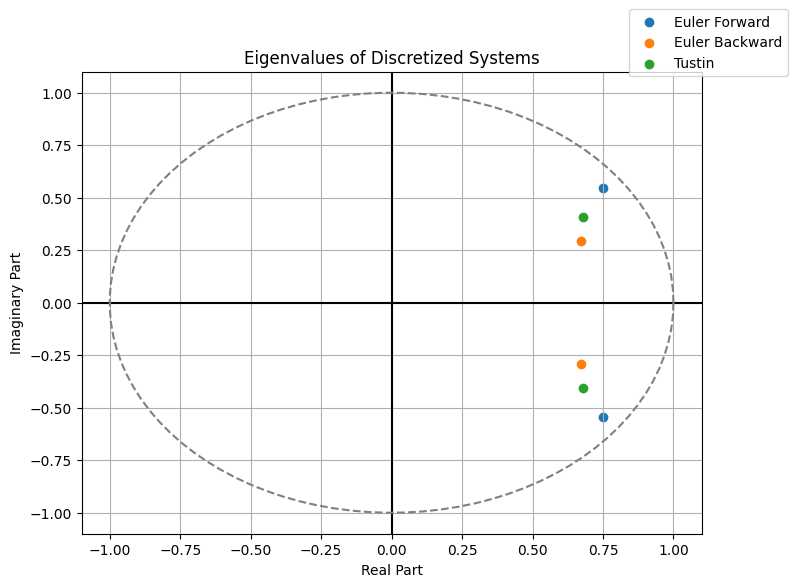

In [149]:
#eigenvalues in c.t. for comparison
print("Eigenvalues of continous system:")
print(np.linalg.eigvals(test.A))
print("\n")

#implement your code here
#------------

dt_forward, dt_backward, dt_tustin = discretize(test, dt)
plot_table(dt_forward, dt_backward, dt_tustin)

#------------

### Conclusion of Exercise 1

In this exercise, we conducted a thorough stability analysis of the Duckiebot steering system using various discretization methods. By employing Euler forward, Euler backward, and Tustin’s methods to discretize the system for a given time step (dt = 1 second), we could observe the distinct impacts these methods have on system stability.

The eigenvalues of the discretized systems were calculated and visually plotted on the complex plane. This visualization, facilitated by the unit circle on the plot, was instrumental in determining the stability of the systems. Systems with eigenvalues lying inside the unit circle are deemed stable in the discrete-time domain.

A key observation from this exercise is the critical role of the discretization method in system stability. Notably, the Euler Forward method often presents a risk of making a stable continuous-time system unstable in the discrete-time domain. This is particularly true for systems with eigenvalues close to the stability boundary. Therefore, careful consideration is required when selecting this method, underscoring the need for a rigorous stability check post-discretization.

This analysis highlights the importance of not only choosing the appropriate discretization method but also thoroughly checking the resulting system's stability, especially when employing the Euler Forward method. Such diligence is crucial in ensuring the reliability and accuracy of digital control systems, particularly in applications where precise control and stability are paramount.

#### Observability check

In [150]:
#check for observability
def observability(system):
    Cd = system.C
    Ad = system.A
    Op = Cd @ Ad
    O = np.row_stack((Cd,Op))
    print(O)
    

observability(dt_forward)
observability(dt_backward)
observability(dt_tustin)

[[1.  1. ]
 [1.4 0.5]]
[[1.         1.        ]
 [1.02150538 0.53763441]]
[[1.         1.        ]
 [1.1641791  0.49253731]]


---------
## Exercise 2: Step Response Simulation and Comparison

Objective: Simulate and compare the step responses of the discretized systems.

Tasks:

	1.Apply a step input to each discretized system.
	2.Simulate the response over a fixed time period (100 seconds).
	3.Plot the responses from all three methods on the same graph for comparison.

### Solution Exercise 2

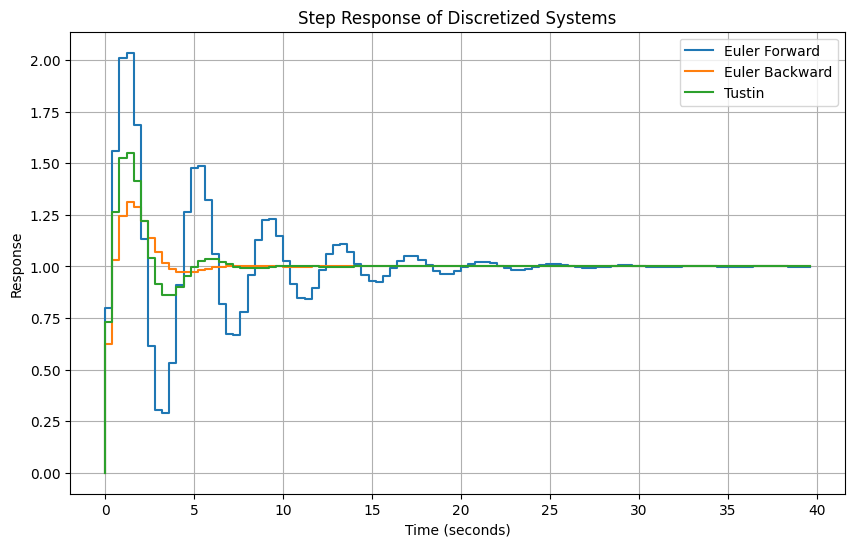

In [151]:
#system 1 (Forward)
def simulate_step_response(system, dt, label, n=100):
    lti = sig.dlti(system.A, system.B, system.C, system.D, dt=dt)
    t, y = sig.dstep(lti, n=n)
    plt.step(t, np.squeeze(y), label=label)

plt.figure(figsize=(10, 6))

# Simulate step response for each method
simulate_step_response(dt_forward, dt, label='Euler Forward')
simulate_step_response(dt_backward, dt, label='Euler Backward')
simulate_step_response(dt_tustin, dt, label='Tustin')

plt.xlabel('Time (seconds)')
plt.ylabel('Response')
plt.title('Step Response of Discretized Systems')
plt.legend()
plt.grid(True)
plt.show()

### Conclusion Exercise 2

In this exercise, we simulated and compared the step responses of systems discretized using Euler Forward, Euler Backward, and Tustin’s methods. A key observation was the unstable step response exhibited by the Euler Forward method, contrasting with the stable responses of the Euler Backward and Tustin methods. This highlights the importance of method selection in system discretization, particularly in scenarios where stability is a critical factor. The exercise demonstrated that while Euler Forward is simple and efficient, it might compromise stability, making Euler Backward and Tustin preferable for certain applications.

--------
## Exercise 3: Performance Analysis under Varying Time Steps

Objective: Evaluate how the choice of time step affects the performance of each discretization method.

Tasks:

	1.Vary the time step (e.g., dt = 0.75, 0.5).
	2.Simulate the step response for each case.
	3.Plot the responses for different time steps and compare how each method reacts to changes in the time step.
	4.Find the biggest time step that makes the system become stable for all approximation methods.
	5.Why does it make sense that the system becomes stable for all approximation methods with a smaller time step?

### Conclusion Exercise 3

In this exercise, we investigated the effect of varying the time step *dt* on the stability of a system discretized using different methods. Our analysis revealed that the largest time step at which the system remains stable is *dt=0.55*. This observation is pivotal in understanding the dynamics of discretization methods and their relationship with time step size.

The key takeaway here is the significance of the time step in determining the accuracy and stability of the discretized system. Smaller time steps lead to a system behavior that more closely approximates the original continuous-time system. Remember, system1 is stable in continuous time. This is because, with smaller increments, the discrete model captures the system's dynamics more frequently, hence providing a finer and more accurate representation of the continuous process. In essence, as the time step decreases, the discretized system converges towards the behavior of the continuous system, thereby enhancing stability.

Therefore, it makes sense that reducing the time step size would result in a more stable system for all discretization methods, including euler forward. This understanding is crucial when designing digital control systems or simulations, where the choice of time step can significantly impact the system's performance and reliability. The exercise underscores the delicate balance between computational efficiency (favoring larger time steps) and system fidelity (favoring smaller time steps), guiding us towards making informed decisions in system design and analysis.

## Exercise 4: Trying out different Systems

Objective: Reapeating the first three exercises and seeing different cases.

Tasks:

	1. Change system1 to system2 in the console cell
	2. Repeat exercises 1-3 with the new system
	Optional: You can also add your own system in the "System Library" and test it

*Hint for creating your own system: Check that your system is observable, by calculating the observaibility matrix. A non observable system will not show you the "true" step response, since it is not displayable.*

## Ende Paolo's Teil
--------------